<a href="https://colab.research.google.com/github/Itsuki-Hamano123/auto_ml/blob/master/auto-keras/Beans/autokeras_img_clf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install git+https://github.com/keras-team/keras-tuner.git@1.0.2rc1
%pip install autokeras
%pip show keras-tuner
%pip show autokeras
%pip show tensorflow

  Cloning https://github.com/keras-team/keras-tuner.git (to revision 1.0.2rc1) to /tmp/pip-req-build-0a19qq1f
  Running command git clone -q https://github.com/keras-team/keras-tuner.git /tmp/pip-req-build-0a19qq1f
  Running command git checkout -q 0fb69434a132093518e0e53d40020145ae192629
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2rc1-cp36-none-any.whl size=85424 sha256=bab1be2ae1f7054049675d9165a505c37a5a93c9be9b1e150f9083b3c0433349
  Stored in directory: /tmp/pip-ephem-wheel-cache-wu2ma4t6/wheels/af/c9/7c/6ea01f9753a5dd1484136b4cb7b33a0a7fba253e5c74ade5af
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=897cb890e205261c475bafe3a75209a54b3189e9e4f5ac8f70569db109aa595b
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables
     |████████████████████████████████| 122kB 4.5MB/s 
Name: keras-tuner
Version: 1.0.2rc1
Summary: 

In [38]:
import tensorflow as tf
import tensorflow_datasets  as tfds
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from autokeras import ImageClassifier

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report

## データの読み込み

In [3]:
def fetch_tf_dataset(data_name, split=['train','validation','test'],
                     shuffle_files=True, as_supervised=True,
                     with_info=True, batch_size=None):
  '''TensorFlowデータセットからデータをフェッチ'''
  (ds_train, ds_val, ds_test), data_info = tfds.load(data_name, split=split,
                                  shuffle_files=shuffle_files,
                                  as_supervised=as_supervised,
                                  with_info=with_info,
                                  batch_size=batch_size)
  return ds_train, ds_val, ds_test, data_info
  


data_name = 'beans' # @param{type:'string'}
x_name = 'image' # @param{type:'string'}
y_name = 'label' # @param{type:'string'}
# インメモリでデータを読み込む
# autokerasのfit関数がdatasetV1Adapter,generatorを受け付けないため
batch_size = -1

# データのフェッチ
ds_train, ds_val, ds_test, ds_info = fetch_tf_dataset(data_name=data_name,
                                     as_supervised=False,
                                     batch_size=batch_size)

display(ds_info)


# numpy配列に変換
# autokerasのfit関数がtf.Tensorを受け付けないため
x_train = ds_train[x_name].numpy()
y_train = ds_train[y_name].numpy()
x_val = ds_val[x_name].numpy()
y_val = ds_val[y_name].numpy()
x_test = ds_test[x_name].numpy()
y_test = ds_test[y_name].numpy()

# 画像のリサイズ
resize_shape = [224, 224]
x_train = tf.image.resize(x_train, resize_shape).numpy()
x_val = tf.image.resize(x_val, resize_shape).numpy()
x_test = tf.image.resize(x_test, resize_shape).numpy()

print('train x shape;{}'.format(x_train.shape))
print('val x shape;{}'.format(x_val.shape))
print('test x shape;{}'.format(x_test.shape))

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incomplete56WYQA/beans-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incomplete56WYQA/beans-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incomplete56WYQA/beans-test.tfrecord


Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='beans',
    version=0.1.0,
    description='Beans is a dataset of images of beans taken in the field using smartphone
cameras. It consists of 3 classes: 2 disease classes and the healthy class.
Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated
by experts from the National Crops Resources Research Institute (NaCRRI) in
Uganda and collected by the Makerere AI research lab.
',
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=1295,
    splits={
        'test': 128,
        'train': 1034,
        'validation': 133,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {beansdata,
        author="Makerere AI Lab",
        title="Bean disease dataset",
        month="January",
        year="2020",
        url="https://gi

train x shape;(1034, 224, 224, 3)
val x shape;(133, 224, 224, 3)
test x shape;(128, 224, 224, 3)


## Auto-Kerasでモデル作成

In [4]:
TASK_NAME = data_name + '_model'
CLASS_NUM = ds_info.features[y_name].num_classes
MAX_TRIALS = 15 #@param {type: "slider", min: 1, max: 50}
SEED = 7

print('クラス数:{}'.format(CLASS_NUM))
print('log dir:{}'.format(TASK_NAME))


clf = ImageClassifier(max_trials=MAX_TRIALS,
                      num_classes=CLASS_NUM, multi_label=False,
                      directory=TASK_NAME, overwrite=True,
                      seed=SEED)

クラス数:3
log dir:beans_model


In [5]:
EPOCHS = 100 #@param {type: "slider", min: 1, max: 200}
es = EarlyStopping(patience=3)


clf.fit(x=x_train, y=y_train, epochs=EPOCHS,
        callbacks=[es], validation_data=(x_val, y_val),
        verbose=1)

Trial 15 Complete [00h 02m 42s]
val_loss: 0.24486082792282104

Best val_loss So Far: 0.23264312744140625
Total elapsed time: 00h 29m 09s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
normalization (Normalization (None, 224, 224, 3)       7         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 64)      0         
_________________________________________________________________
global_max_pooling2d (Global (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)               

None

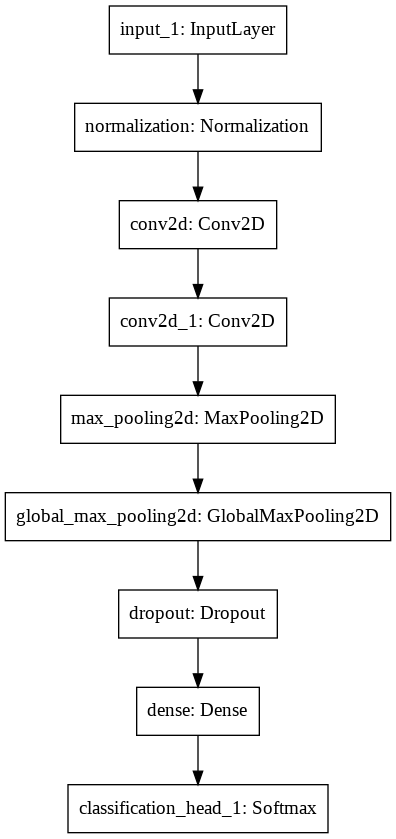

In [11]:
best_clf = clf.export_model()
display(best_clf.summary())
plot_model(best_clf)

## モデルの評価

In [7]:
def evalute_model(model, x, y_true):
  '''モデルの評価関数呼び出し'''
  score = model.evaluate(x=x, y=y_true)
  return score


train_score = evalute_model(clf, x_train, y_train)
val_score = evalute_model(clf, x_val, y_val)
test_score = evalute_model(clf, x_test, y_test)
print('訓練 loss:{loss}, 正答率:{auc}'.format(loss=train_score[0], auc=train_score[1]))
print('検証 loss:{loss}, 正答率:{auc}'.format(loss=val_score[0], auc=val_score[1]))
print('テスト loss:{loss}, 正答率:{auc}'.format(loss=test_score[0], auc=test_score[1]))

4/4 [==============================] - 0s 28ms/step - loss: 0.3741 - accuracy: 0.8672
訓練 loss:0.1352865844964981, 正答率:0.9738878011703491
検証 loss:0.23264312744140625, 正答率:0.9097744226455688
テスト loss:0.3741299510002136, 正答率:0.8671875


----- 訓練データ レポート-----


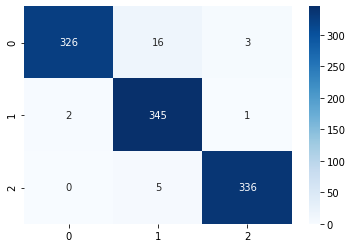

              precision    recall  f1-score   support

           0       0.99      0.94      0.97       345
           1       0.94      0.99      0.97       348
           2       0.99      0.99      0.99       341

    accuracy                           0.97      1034
   macro avg       0.97      0.97      0.97      1034
weighted avg       0.97      0.97      0.97      1034

----------
----- 検証データ レポート-----


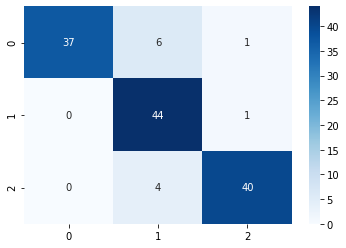

              precision    recall  f1-score   support

           0       1.00      0.84      0.91        44
           1       0.81      0.98      0.89        45
           2       0.95      0.91      0.93        44

    accuracy                           0.91       133
   macro avg       0.92      0.91      0.91       133
weighted avg       0.92      0.91      0.91       133

----------
----- テストデータ レポート-----


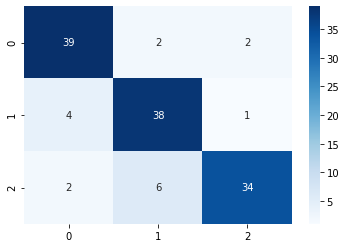

              precision    recall  f1-score   support

           0       0.87      0.91      0.89        43
           1       0.83      0.88      0.85        43
           2       0.92      0.81      0.86        42

    accuracy                           0.87       128
   macro avg       0.87      0.87      0.87       128
weighted avg       0.87      0.87      0.87       128

----------


In [36]:
def _calc_sk_metric(sk_metric, y_true, y_pred):
  '''sklearnの評価関数を使う'''
  result = sk_metric(y_true, y_pred)
  return result


def print_sk_metrics(sk_metrics, y_true, y_pred, data_name=None):
  '''sklearnの評価指標の計算結果を画面に出力'''
  print('----- {} レポート-----'.format(data_name))
  for sk_metric in sk_metrics:
    report = _calc_sk_metric(sk_metric, y_true, y_pred)
    
    if(sk_metric.__name__ == 'confusion_matrix'):
      plt.show(sns.heatmap(report, annot=True, fmt='d', cmap='Blues'))
    else:
      print(report)

  print('----------')


use_sk_metrics = [confusion_matrix, classification_report]


# 訓練データに対する評価
y_train_pred = clf.predict(x_train)
print_sk_metrics(sk_metrics=use_sk_metrics, y_true=y_train,
                 y_pred=y_train_pred, data_name='訓練データ')

# 検証データに対する評価
y_val_pred = clf.predict(x_val)
print_sk_metrics(sk_metrics=use_sk_metrics, y_true=y_val,
                 y_pred=y_val_pred, data_name='検証データ')

# テストデータに対する評価
y_test_pred = clf.predict(x_test)
print_sk_metrics(sk_metrics=use_sk_metrics, y_true=y_test,
                 y_pred=y_test_pred, data_name='テストデータ')